In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm


In [2]:
def load_data():
    # 数据预处理
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    # 加载数据MNIST, 训练集和测试集(train=True/False), 转换为张量(附带归一化 /255), 下载数据
    train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
    test_data = datasets.MNIST(root='data', train=False, transform=transform, download=True)
    
    # 数据加载器 DataLoader, 用于将数据分批次加载, shuffle=True表示打乱数据
    train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)
    return train_loader, test_loader

In [3]:
# 定义生成器和判别器
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(1, 28, 28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_shape=(1, 28, 28)):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [4]:
# 训练函数
def train_gan(generator, discriminator, train_loader, g_optimizer, d_optimizer, n_epochs, device):
    generator.train()
    discriminator.train()

    for epoch in range(n_epochs):
        for i, (real_imgs, _) in enumerate(tqdm(train_loader)):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # 训练判别器
            d_optimizer.zero_grad()
            real_validity = discriminator(real_imgs)
            z = torch.randn(batch_size, 100, device=device)
            fake_imgs = generator(z)
            fake_validity = discriminator(fake_imgs)

            d_loss = -torch.mean(torch.log(real_validity) + torch.log(1 - fake_validity))
            d_loss.backward()
            d_optimizer.step()

            # 训练生成器
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, 100, device=device)
            fake_imgs = generator(z)
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(torch.log(fake_validity))
            g_loss.backward()
            g_optimizer.step()

        print(f"Epoch [{epoch + 1}/{n_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")


In [5]:
# 可视化生成的图像
def visualize_generated_images(generator, device, num_images=64):
    z = torch.randn(num_images, 100, device=device)
    gen_imgs = generator(z).detach().cpu()
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(8, 8, i + 1)
        plt.imshow(gen_imgs[i, 0], cmap='gray')
        plt.axis('off')
    plt.show()

In [6]:
# 初始化生成器和判别器
generator = Generator()
discriminator = Discriminator()

# 设置优化器
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
train_loader,_ = load_data()
n_epochs = 5
train_gan(generator, discriminator, train_loader, g_optimizer, d_optimizer, n_epochs, device)


100%|██████████| 1875/1875 [00:10<00:00, 173.62it/s]


Epoch [1/5], D_loss: 0.7325, G_loss: 1.7792


100%|██████████| 1875/1875 [00:10<00:00, 177.29it/s]


Epoch [2/5], D_loss: 0.6112, G_loss: 1.2921


100%|██████████| 1875/1875 [00:10<00:00, 180.96it/s]


Epoch [3/5], D_loss: 0.9304, G_loss: 1.6513


100%|██████████| 1875/1875 [00:10<00:00, 179.22it/s]


Epoch [4/5], D_loss: 0.8569, G_loss: 1.5918


100%|██████████| 1875/1875 [00:10<00:00, 176.57it/s]

Epoch [5/5], D_loss: 1.0593, G_loss: 1.2447


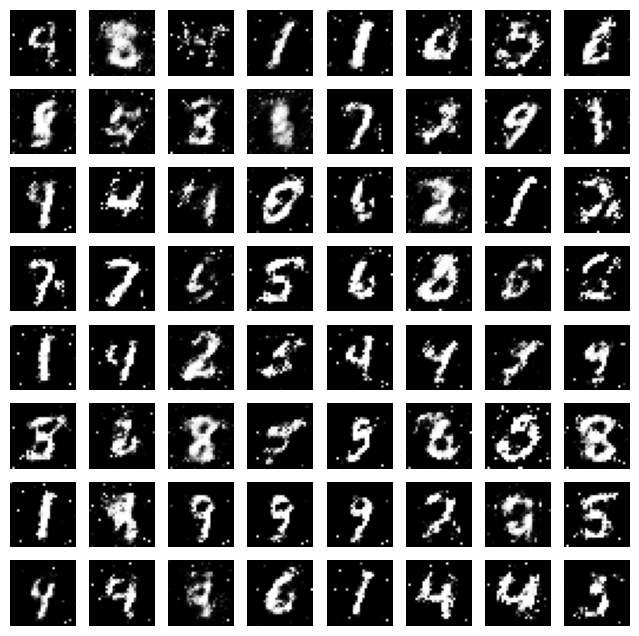

In [8]:
# 可视化生成的图像
visualize_generated_images(generator, device)